# Visualizing hierarchical image segmentations


In hierarchical image analysis, the dendrogram visualization which is classically used to represent hierarchical clustering in data analysis is often not very informative because it cannot represent the natural embedding of the pixels (the leaves of the dendrogram) in the 2d space and it is often very complex. 

This notebook demonstrates two technics for visualizing hierarchical image segmentations: 

1. through their saliency maps (also called ultrametric contour maps) where the contours of the regions 
   of the hierarchy are plotted with an intensity proportional to their altitude in the hierarchy.
2. through their horizontal cuts, ie. by sequentially observing different levels of the hierarchy.

## 0. Preparation

### Imports

In [1]:
%%capture
!pip install higra

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from skimage import data
from skimage.transform import rescale
import imageio
import higra as hg

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, IntSlider, BoundedIntText

try:
    from utils import * # imshow, locate_resource
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

### Image loading and demo hierarchy creation

Image size: (241, 361)


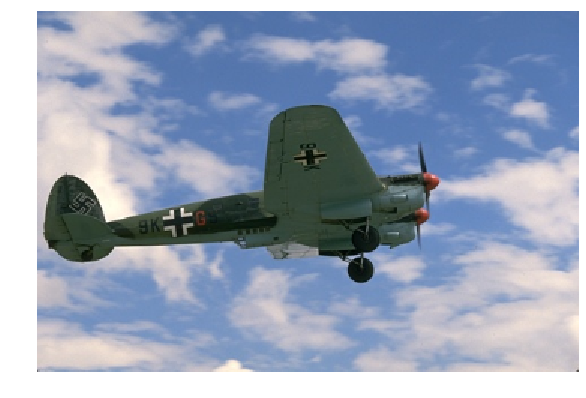

In [3]:
image = imageio.imread(locate_resource("3063.ppm"))
image = image.astype(np.float32)/255 

# a bit smaller for small screens
image = rescale(image, 0.75, multichannel=True)

# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image);

detector = cv2.ximgproc.createStructuredEdgeDetection(get_sed_model_file())
gradient_image = detector.detectEdges(image.astype(np.float32))
#imshow(gradient_image);

graph = hg.get_4_adjacency_graph(size)
edge_weights = hg.weight_graph(graph, gradient_image, hg.WeightFunction.mean)

tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)
altitudes /= altitudes.max()

### Horizontal cut explorer

The class ``HorizontalCutExplorer`` of Higra helps to explore and to browse the horizontal cuts of a valued hierarchy. Construction of the HorizontalCutExplorer if performed in linear time $\mathcal{O}(n)$ w.r.t. the number of nodes $n$ in the tree. Each cut of the hierarchy can be accessed through:

1. its index (the first single region cut has index 0). This operation runs in $\mathcal{O}(k)$, with $k$ the number of regions in the retrieved cut ;
2. the number of regions in the cut (the smallest partition having at least the given number of regions is found). This operation runs in $\mathcal{O}(k\log n)$, with $k$ the number of regions in the retrieved cut;
3. the altitude of the cut. This operation runs in $\mathcal{O}(k\log n)$, with $k$ the number of regions in the retrieved cut.

In [4]:
explorer = hg.HorizontalCutExplorer(tree, altitudes)

## Saliency maps

When a graph $G$ is a 4-adjacency graph defined on a regular grid of pixels, a cut of this graph can be represented by an image of contours where edges are reprented as inter-pixels showing the indicator function of the cut. Such *interpolated* space is refered as the *2d Khalimsky grid* or as *2d cubical complexes*.
A hierarchy of segmentation can be seen a sequence of nested cuts of the base graph, it is thus also possible to plot all those cuts in the Khalimsky grid, each cut being represented at a level proportional to its altitude, to obtain an image representing the hierarchy.

In [5]:
# this saliency corresponds to edge weights on the base graph
saliency = hg.saliency(tree, altitudes)
# we embedd the saliency values in the Khalimsky grid
saliency_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, saliency)

The appearance of the saliency map can be greatly influenced by the choice of the transfer function that maps altitude values to gray level. Here, we use a simple gamma correction $t\rightarrow t^\gamma$ where the coefficient $\gamma$ can be modified dynamically to see the effect on the visualization.

In [6]:
def show_saliency(gamma=0.5):
    imshow(1-saliency_khalimsky**gamma, cmap="gray");

interact(show_saliency, gamma= FloatSlider(min=0.01, max=2, continuous_update=False, value=0.5, step=0.05));

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='gamma', max=2.0, min=0.01, …

A way to further improve the visualization is to introduce a cut-off level in the transfer function to get rid of the low levels of the hierarchy which usually correspond to low level features of the image. The transfert function becomes:

$$t\rightarrow \begin{cases}0 \textrm{ if } t < \alpha_k \\ t^\gamma \textrm{ otherwise}\end{cases} $$

where $\alpha_k$ is the altitude of the highest cut containing at least $k$ regions. We will use the object ``HorizontalCutExplorer`` to compute $\alpha_k$.

In [7]:
def show_saliency(num_regions=200, gamma=0.5):
    cut = explorer.horizontal_cut_from_num_regions(num_regions)
    cut_altitude = cut.altitude()
    filtered_saliency = np.where(saliency_khalimsky>=cut_altitude, saliency_khalimsky, cut_altitude)
    filtered_saliency = (filtered_saliency - cut_altitude) / (1 - cut_altitude)
    imshow(1-filtered_saliency**gamma, cmap="gray");

interact(show_saliency, 
         num_regions = IntSlider(min=3, max=500, continuous_update=False, value=100, step=1),
         gamma= FloatSlider(min=0.01, max=2, continuous_update=False, value=0.5, step=0.05));

interactive(children=(IntSlider(value=100, continuous_update=False, description='num_regions', max=500, min=3)…

## 2. Horizontal cuts

In this second approach we colorize the regions of an horizontal cut to better visualize them. We provide two options for colorization: either with the average color of the region or with a random color. The cut to be displayed is chosen by selecting a target number of regions.

In [8]:
# compute average color and random color for nodes
mean_color = hg.attribute_mean_vertex_weights(tree, image)
random_color = np.random.rand(tree.num_vertices(), 3)

In [9]:
def show_cut(num_regions, fill='Mean Color', show_frontiers=True, mode='At least n regions'):
    cut_nodes = explorer.horizontal_cut_from_num_regions(num_regions, at_least=(mode == 'At least n regions'))
    print("Cut with %d regions at altitude %3.2f"%(len(cut_nodes.nodes()), cut_nodes.altitude()))

    im = cut_nodes.reconstruct_leaf_data(tree, mean_color if fill=="Mean Color" else random_color)

    if show_frontiers:
        cut = cut_nodes.graph_cut(tree)
        cut_khal = hg.graph_4_adjacency_2_khalimsky(graph, cut)

        im_khal = np.zeros([size[0] * 2 - 1, size[1] * 2 - 1, 3], dtype=np.float32)
        im_khal[0::2, 0::2, :] = im
        im_khal[0::2, 1::2, :] = im_khal[0::2, 0:-1:2, :]
        im_khal[1::2, 0::2, :] = im_khal[0:-1:2, 0::2, :]
        im_khal[1::2, 1::2, :] = im_khal[0:-1:2, 0:-1:2, :]

        frontiers = cut_khal != 0
        im_khal[frontiers, :] = 0
        im = im_khal

    imshow(im)


import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, IntSlider, BoundedIntText

interact(show_cut, 
         num_regions = IntSlider(min=1, max=300, continuous_update=False, value=20, step=1),
         mode=["At least n regions", "At most n regions"],
         fill=["Mean Color", "Random Color"], 
         show_frontiers=True);

interactive(children=(IntSlider(value=20, continuous_update=False, description='num_regions', max=300, min=1),…